# Оптимизация цены (для оптимизации дохода)

In [111]:
import numpy as np
from tqdm import tqdm
from IPython.display import display, Javascript
import json
from collections import namedtuple
from numpy.random import uniform, seed
from numpy import floor

import warnings

warnings.simplefilter("ignore")

##### набор функций

`demand` - это зависимость, которая показывает спрос

In [112]:
def _qnt_sold(p, demand_level, max_qty):
    # расчет количества подаж и зависимости
    quantity_demanded = floor(max(0, p - demand_level))
    return min(quantity_demanded, max_qty)


def simulate_revenue(days_left, qnt_left, pricing_function, 
                     rev_to_date=0, demand_level_min=100, demand_level_max=200, 
                     verbose=False):
    
    # моделирование дохода от функции цены и события
    if (days_left == 0) or (qnt_left == 0):
        
        if verbose:
            # проверка кол-во дней
            if (days_left == 0):
                print("Кол-во на день закончено.")
                
            # проверка на кол-во штук
            if (qnt_left == 0):
                print("Расчет на компанию закончен")
            print("Итоговый доход: {:.0f}".format(rev_to_date))
        return rev_to_date
    
    else:
        
        demand_level = uniform(demand_level_min, demand_level_max)
        p = pricing_function(days_left, qnt_left, demand_level)
        q = _qnt_sold(demand_level, p, qnt_left)
        
        if verbose:
            print("{:.0f} дней до конца продаж: \n"
                  "Всего {:.0f} штук на акцию. \n"
                  "Уровень зависимостей (спроса): {:.0f}. \n"
                  "Цена установлена на {:.0f}. \n"
                  "Продано {:.0f} штук. \n"
                  "Дневной доход {:.0f}. Доход всего {:.0f}. \n"
                  "{:.0f} осталось штук\n".format(days_left, qnt_left, demand_level, 
                                                p, q, p*q, p*q+rev_to_date, qnt_left-q))
            
            
        return simulate_revenue(days_left = days_left-1,
                              qnt_left = qnt_left-q,
                              pricing_function=pricing_function,
                              rev_to_date=rev_to_date + p * q,
                              demand_level_min=demand_level_min,
                              demand_level_max=demand_level_max,
                              verbose=verbose)


In [113]:
def score_me(pricing_function, sims_per_scenario=200):
    
    # Расчет среднего дохода за событие
    # => применяем для сравнения алгоритмов

    seed(0)
    Scenario = namedtuple('Scenario', 'n_days n_qnt')
    scenarios = [Scenario(n_days=100, n_qnt=100), Scenario(n_days=14, n_qnt=50),
                 Scenario(n_days=2, n_qnt=20), Scenario(n_days=1, n_qnt=3),
                 ]
    scenario_scores = []
    
    for s in scenarios:
        
        scenario_score = sum(simulate_revenue(s.n_days, s.n_qnt, pricing_function)
                             for _ in range(sims_per_scenario)) / sims_per_scenario
        
        print("Запуск компанни {:.0f} на {:.0f} дней, в {:.0f} штуках. \n"
              "Средний доход: {:.0f}".format(sims_per_scenario, s.n_days, s.n_qnt, scenario_score))
        
        scenario_scores.append(scenario_score)
    
    score = sum(scenario_scores) / len(scenario_scores)
    
    print("Средний доход по всем компаниям {:.0f}\n".format(score))

In [114]:
def basic_pricing_function(days_left, qnt_left, demand_level):
    # простая функция установки цены
    price = demand_level - 10
    return price

### Тестирование

In [115]:
simulate_revenue(days_left=7, qnt_left=50, pricing_function=basic_pricing_function, verbose=True)

7 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 131. 
Цена установлена на 121. 
Продано 10 штук. 
Дневной доход 1207. Доход всего 1207. 
40 осталось штук

6 дней до конца продаж: 
Всего 40 штук на акцию. 
Уровень зависимостей (спроса): 175. 
Цена установлена на 165. 
Продано 10 штук. 
Дневной доход 1654. Доход всего 2861. 
30 осталось штук

5 дней до конца продаж: 
Всего 30 штук на акцию. 
Уровень зависимостей (спроса): 159. 
Цена установлена на 149. 
Продано 10 штук. 
Дневной доход 1494. Доход всего 4355. 
20 осталось штук

4 дней до конца продаж: 
Всего 20 штук на акцию. 
Уровень зависимостей (спроса): 183. 
Цена установлена на 173. 
Продано 10 штук. 
Дневной доход 1732. Доход всего 6088. 
10 осталось штук

3 дней до конца продаж: 
Всего 10 штук на акцию. 
Уровень зависимостей (спроса): 134. 
Цена установлена на 124. 
Продано 10 штук. 
Дневной доход 1238. Доход всего 7325. 
0 осталось штук

Расчет на компанию закончен
Итоговый доход: 7325


7325.441326802741

### Алгоритм оптимизации



In [116]:
def pricing_function0(days_left, qnt_left, demand_level):
    # функция оптимизации дохода (p* = demand / 2)
    # расчет до конца компании
    if days_left == 1 :
        price = demand_level - qnt_left
    else:
        price = min (demand_level/2, demand_level - qnt_left)

    return price

In [117]:
def pricing_function1(days_left, qnt_left, demand_level):
    # простой подход, при котором мы продаем только в том случае,
    # если спрос достаточно высок, что позволяет повысить цены
    if days_left == 1 :
        price = demand_level - qnt_left
    else:
        if demand_level < 175:
            price = demand_level  # считаем, что 175 - это малый спрос
        else:
            price = min (200 - qnt_left, demand_level - qnt_left/2)  # если спрос больше 175, то он высокий
            
    return price

In [118]:
def pricing_function2(days_left, qnt_left, demand_level):
    # продаем если кол-во пропорциональное вероятности увеличения спроса 
    # и количеству оставшихся дней
    if days_left == 1 :
        price = demand_level - qnt_left
    else:
        if days_left > 4:
            sell = min(qnt_left, qnt_left / days_left * 1 / ((200 - demand_level)/ 100) )
            price = max(0,200 - sell)
        else:
            sell = min(qnt_left, qnt_left / days_left * 1 / ((200 - demand_level)/ 100) )
            price = max(0,demand_level - sell)
        
    return price

In [119]:
def pricing_function3(days_left, qnt_left, demand_level):
    # оптимизация при высоком уровне спроса
    if days_left == 1 :
        price = demand_level - qnt_left
    else:
        if days_left > 3:
            price = 200 - qnt_left/2
        elif days_left <= 3:
            price = 175 - qnt_left/2
        else:
            price = 150 - qnt_left
    return price

In [120]:
def pricing_function4(days_left, qnt_left, demand_level):
    # только небольшое количество и только в том случае, если спрос превышает 170
    if days_left == 1 :
        price = demand_level - qnt_left
    else:
        if demand_level < 170:
            price = demand_level
        else:
            price = demand_level-10

    return price

In [121]:
def pricing_function5(days_left, qnt_left, demand_level):
    # только в том случае, если спрос превышает 173, 
    # и количество ещё достаточное, чтобы успеть продать в любой ситуации
    if days_left == 1:
        price = demand_level - qnt_left
        
    # продать 10% штук за последние 2 дня, по цене выше средней
    elif days_left == 2 and demand_level > 150:
        price = 0.9*demand_level
        
    # продавать если спрос превышает 173
    elif demand_level > 173:
        price = demand_level - (qnt_left - days_left)/2
    else:
        price = demand_level #заглушка - не продавать
    return price

In [122]:
for index, f in enumerate([pricing_function0, pricing_function1, pricing_function2, 
                           pricing_function3, pricing_function4, pricing_function5]):
    
    print('\|/Запуск функции {} :'.format(index))
    
    score_me(f, 200)

\|/Запуск функции 0 :
Запуск компанни 200 на 100 дней, в 100 штуках. 
Средний доход: 5004
Запуск компанни 200 на 14 дней, в 50 штуках. 
Средний доход: 3728
Запуск компанни 200 на 2 дней, в 20 штуках. 
Средний доход: 1503
Запуск компанни 200 на 1 дней, в 3 штуках. 
Средний доход: 434
Средний доход по всем компаниям 2667

\|/Запуск функции 1 :
Запуск компанни 200 на 100 дней, в 100 штуках. 
Средний доход: 10997
Запуск компанни 200 на 14 дней, в 50 штуках. 
Средний доход: 7681
Запуск компанни 200 на 2 дней, в 20 штуках. 
Средний доход: 2729
Запуск компанни 200 на 1 дней, в 3 штуках. 
Средний доход: 431
Средний доход по всем компаниям 5459

\|/Запуск функции 2 :
Запуск компанни 200 на 100 дней, в 100 штуках. 
Средний доход: 14612
Запуск компанни 200 на 14 дней, в 50 штуках. 
Средний доход: 7684
Запуск компанни 200 на 2 дней, в 20 штуках. 
Средний доход: 2784
Запуск компанни 200 на 1 дней, в 3 штуках. 
Средний доход: 433
Средний доход по всем компаниям 6378

\|/Запуск функции 3 :
Запуск ком

**Заключение:**

Мы можем выбрать оптимальную стратегию продаж (теоретическую). Которая состоит из запусков компаний, штук и длительности.

### Brute Force алгоритм

In [123]:
# дней = 100
# максимальное кол-во  = 100

n = 100

# заполним матрицу последовательносями дней (0->100), кол-вом (0->100) и спросом (100->200)
optimal_prices = np.zeros((n+1, n+1, n+1), dtype='uint8') 

# ожидаемая выгода (пустой шаблон)
optimal_sales = np.zeros((n+1, n+1), dtype=np.float)      


# пройдемся с 1 дня и до конца компании
for qnt_left in range(n+1):
    
    for demand in range(n, 2*n+1):
        
        # demand / 2
        qnt_sold = min(demand // 2, qnt_left) 
        price = demand - qnt_sold
        
        optimal_prices[1, qnt_left, demand - 100] = price
        
        # Ожидаемый обещенный доход.
        optimal_sales[1, qnt_left] += (price * qnt_sold / 101)
        
# создаем таблицу для расчета алгоритма
for days_left in tqdm(range(2, n+1)):
    
    for qnt_left in range(n+1):
        
        last_best_price = 0 #если есть предыдущий уровень
        
        for demand in range(n, 2*n+1):
            
            # поиск лучшей цены в контексте дня: days_left, qnt_left, demand_level
            best_revenue = 0
            best_price = 0
                        
            # поиск цены
            for price in range(max(demand - qnt_left, last_best_price), demand+1): 
                
                qbt_sold = min(demand - price, qnt_left) 
                revenue = price * qnt_sold + optimal_sales[days_left - 1, qnt_left - qnt_sold] 
                
                # обновление лучшего дохода и цены
                if revenue > best_revenue: 
                    best_revenue, best_price = revenue, price
            
            # установка оптимальной цены
            optimal_prices[days_left, qnt_left, demand-100] = best_price
            optimal_sales[days_left, qnt_left] += (best_revenue / 101)
            last_best_price = best_price

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 26.43it/s]


In [124]:
def pricing_function_6(days_left, qnt_left, demand_level):
    # расчет функции после алгоритма
    qnt_left = int(qnt_left)
    demand_level = int(demand_level)
    
    return optimal_prices[days_left, qnt_left, demand_level-100] # Return the precomputed values

In [125]:
print('Функция Brute Force:')

simulate_revenue(days_left=7, qnt_left=50, pricing_function=pricing_function_6, verbose=True)
score_me(pricing_function_6, 200)

Функция Brute Force:
7 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 130. 
Цена установлена на 130. 
Продано 0 штук. 
Дневной доход 0. Доход всего 0. 
50 осталось штук

6 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 135. 
Цена установлена на 135. 
Продано 0 штук. 
Дневной доход 0. Доход всего 0. 
50 осталось штук

5 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 102. 
Цена установлена на 101. 
Продано 0 штук. 
Дневной доход 0. Доход всего 0. 
50 осталось штук

4 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 191. 
Цена установлена на 191. 
Продано 0 штук. 
Дневной доход 0. Доход всего 0. 
50 осталось штук

3 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 174. 
Цена установлена на 174. 
Продано 0 штук. 
Дневной доход 0. Доход всего 0. 
50 осталось штук

2 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (сп

### Dynamic алгоритм

In [128]:
# два набора данных для расчета
savedF = {}
savedG = {}                                  

def getF(qnt,days):
    
    if qnt<=0 or days <= 0:
        return 0
    if (qnt,days) in savedF:
        return savedF[(qnt,days)]
    
    res = 0.0
    
    #ожидаемый результат
    for i in range(100, 201):
        res += getG(qnt, days, i)[0]
    res /= 101
    
    savedF[(qnt,days)] = res
    return res

def getG(qnt, days, demand):
    
    if days <= 0 or qnt <= 0:
        return (0,0)
    if (qnt, days, demand) in savedG:
        return savedG[(qnt, days, demand)]
    
    topTotal = -1
    topPrice = -1
    
    for i in range(1, demand+1):
        res = min(demand-i, qnt)*i + (getF(qnt-(demand-i), days-1) if qnt-(demand-i) > 0 else 0)
        if res > topTotal:
            topTotal, topPrice = res, i
            
    savedG[(qnt, days, demand)] = (topTotal, topPrice)
    return (topTotal, topPrice)

In [129]:
def pricing_function_7(days_left, qnt_left, demand_level):
    # функция запуска алгоритма
    demand_level_floor = int(floor(demand_level))
    demand_delta = demand_level - demand_level_floor
    (topTotal, topPrice) = getG(qnt_left, days_left, demand_level_floor)
    return topPrice + demand_delta - 0.00001

In [130]:
print('Запуск оптимизации:')
simulate_revenue(days_left=7, qnt_left=50, pricing_function=pricing_function_7, verbose=True)
score_me(pricing_function_7, 200)

Запуск оптимизации:
7 дней до конца продаж: 
Всего 50 штук на акцию. 
Уровень зависимостей (спроса): 143. 
Цена установлена на 141. 
Продано 2 штук. 
Дневной доход 281. Доход всего 281. 
48 осталось штук

6 дней до конца продаж: 
Всего 48 штук на акцию. 
Уровень зависимостей (спроса): 145. 
Цена установлена на 141. 
Продано 4 штук. 
Дневной доход 562. Доход всего 844. 
44 осталось штук

5 дней до конца продаж: 
Всего 44 штук на акцию. 
Уровень зависимостей (спроса): 174. 
Цена установлена на 158. 
Продано 16 штук. 
Дневной доход 2523. Доход всего 3366. 
28 осталось штук

4 дней до конца продаж: 
Всего 28 штук на акцию. 
Уровень зависимостей (спроса): 131. 
Цена установлена на 131. 
Продано 0 штук. 
Дневной доход 0. Доход всего 3366. 
28 осталось штук

3 дней до конца продаж: 
Всего 28 штук на акцию. 
Уровень зависимостей (спроса): 141. 
Цена установлена на 135. 
Продано 6 штук. 
Дневной доход 808. Доход всего 4175. 
22 осталось штук

2 дней до конца продаж: 
Всего 22 штук на акцию. 
Ур

### Визуализация

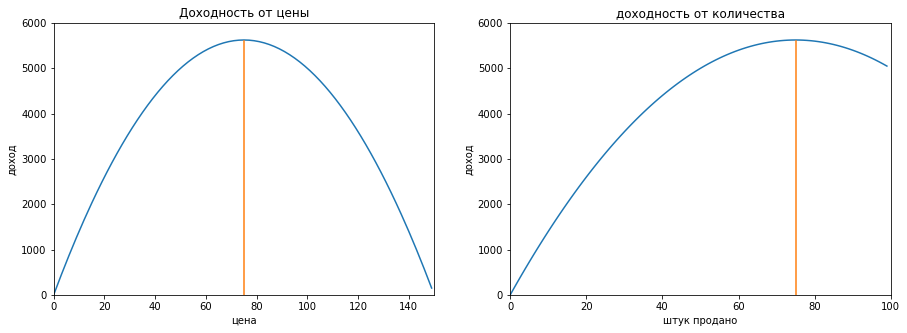

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x = np.arange(0, 150)
y = x * (150 - x)
plt.ylim(0,6000)
plt.xlim(0,150)
plt.plot(x,y)
plt.plot((75,75), (0,5600))
plt.title('Доходность от цены')
plt.xlabel('цена')
plt.ylabel('доход')

plt.subplot(1,2,2)
x = np.arange(0, 100)
y = x * (150 - x)
plt.ylim(0,6000)
plt.xlim(0,100)
plt.plot(x,y)
plt.plot((75,75), (0,5600))
plt.title('доходность от количества')
plt.xlabel('штук продано')
plt.ylabel('доход')

plt.show()